In [32]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
raw = pd.read_csv ("../datasets/temperatura_e_potencia2.csv", header=0)
raw.head()

,momento,pa,temp_celsius,pressao
0,2019-02-18 00:00:00-03,20.377751,24,1013.0
1,2019-02-18 01:00:00-03,20.274133,24,1012.6
2,2019-02-18 02:00:00-03,20.112670,24,1012.3
3,2019-02-18 03:00:00-03,20.260007,23,1011.8
4,2019-02-18 04:00:00-03,20.181787,23,1011.3


# Data cleaning

In [34]:
processed = raw.dropna()
processed = processed.set_index(pd.to_datetime (processed['momento'])).drop('momento', axis=1)
processed = processed[processed['pa']<500]
processed = processed[processed['pa']>10]

In [35]:
## Remove fins de semana
# Create an index of just the date portion of your index (this is the slow step)
dfDays = pd.to_datetime(processed.index.date)

# Create a range of business days over that period
dfBdays = pd.bdate_range(start=processed.index[0].date(), end=processed.index[-1].date())

#Filter the series to just those days contained in the business day range.
filtered = processed[dfDays.isin(dfBdays)]

In [36]:
## Removendo dias não-letivos ou com erros
# março 4,5,6
# abril 8, 15, 16,17,18,19, 22, 25, 29
# maio 1, 9, 10, 14, 15, 16, 17
# junho 20, 21
filtered = filtered[~((filtered.index.month == 3) & (filtered.index.day == 4))]
filtered = filtered[~((filtered.index.month == 3) & (filtered.index.day == 5))]
filtered = filtered[~((filtered.index.month == 3) & (filtered.index.day == 6))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 8))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 4))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 15))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 16))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 17))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 18))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 19))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 22))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 25))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 29))]
filtered = filtered[~((filtered.index.month == 5) & (filtered.index.day == 1))]
filtered = filtered[~((filtered.index.month == 5) & (filtered.index.day == 9))]
filtered = filtered[~((filtered.index.month == 5) & (filtered.index.day == 10))]
filtered = filtered[~((filtered.index.month == 5) & (filtered.index.day == 14))]
filtered = filtered[~((filtered.index.month == 5) & (filtered.index.day == 15))]
filtered = filtered[~((filtered.index.month == 5) & (filtered.index.day == 16))]
filtered = filtered[~((filtered.index.month == 5) & (filtered.index.day == 17))]
filtered = filtered[~((filtered.index.month == 6) & (filtered.index.day == 20))]
filtered = filtered[~((filtered.index.month == 6) & (filtered.index.day == 21))]

In [37]:
filtered1 = filtered.between_time('08:00:00', '11:00:00')
filtered2 = filtered.between_time('14:00:00', '17:00:00')

filtered = pd.concat([filtered1, filtered2])

# Random forest algorithm

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import math

# split 70% of training 30% of test
X = filtered.drop('pa', axis=1)
y = filtered ['pa']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20) 

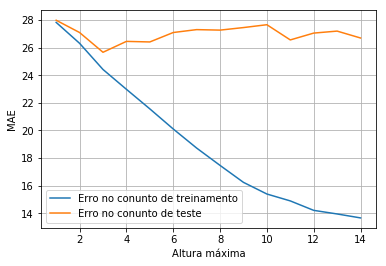

In [58]:
mae1 = {}
mae2 = {}
for k in range(1,15, 1):
    model = RandomForestRegressor(max_depth=k, n_estimators=100, criterion='mae').fit(X_train,y_train)
    y_hat = model.predict(X_train)
    mae1[k] = metrics.mean_absolute_error(y_train,y_hat)
    y_hat = model.predict(X_test)
    mae2[k] = metrics.mean_absolute_error(y_test,y_hat)

plt.figure()
plt.plot(list(mae1.keys()), list(mae1.values()), label='Erro no conunto de treinamento')
plt.plot(list(mae2.keys()), list(mae2.values()), label='Erro no conunto de teste')
plt.legend(loc='lower left')
plt.xlabel("Altura máxima")
plt.ylabel("MAE")
plt.grid(True)

In [59]:
# Random Forest
model = RandomForestRegressor(max_depth=3, n_estimators=100)
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [60]:
# TEST
y_hat = model.predict(X_test)

print ("MAE:                ", metrics.mean_absolute_error(y_test,y_hat))
print ("RMSE:               ", math.sqrt(metrics.mean_squared_error(y_test,y_hat)))

# Feature analysis
print ("=====================================")
print ("FEATURE IMPORTANCE:")
for i in range(model.feature_importances_.size):
    print (X_train.columns[i], "=", model.feature_importances_[i])

MAE:                 26.579944019722312
RMSE:                33.389415205065426
FEATURE IMPORTANCE:
temp_celsius = 0.8891526604748133
pressao = 0.11084733952518666


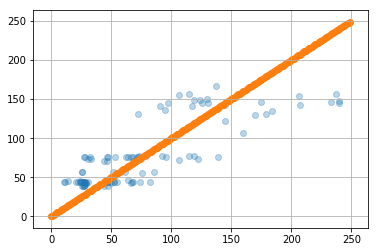

In [61]:
# Previsto vs real
line = np.arange(0, 250, 1)

plt.scatter(y_test,y_hat, Alpha=0.3)
plt.scatter(line,line)
plt.grid(True)

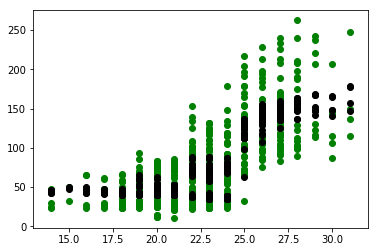

In [43]:
plt.scatter(X['temp_celsius'], y,color='g')
plt.scatter(X['temp_celsius'], model.predict(X),color='k')

plt.show()